## BurgerKing

In [1]:
# !pip install pyarrow
# !pip install fastparquet

In [128]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import f1_score

from tqdm import tqdm, trange

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Убираем ограничение отображемых колонок
pd.options.display.max_columns = None

### Загружаем датасет

In [4]:
burger_df = pd.read_parquet('datasets/train_dataset_hackaton2023_train.gzip')
burger_df.shape

(12129384, 9)

In [5]:
test_burger_df = pd.read_parquet('datasets/test_dataset_hackaton2023_test.gzip')
test_burger_df.shape

(2498034, 7)

<Axes: >

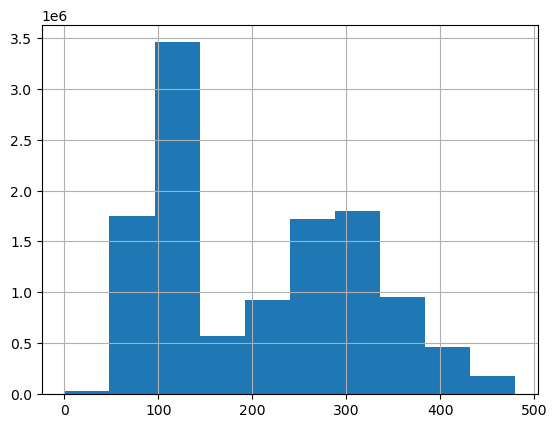

In [210]:
burger_df[burger_df['ownareaall_sqm'] < 500]['ownareaall_sqm'].hist()

<Axes: >

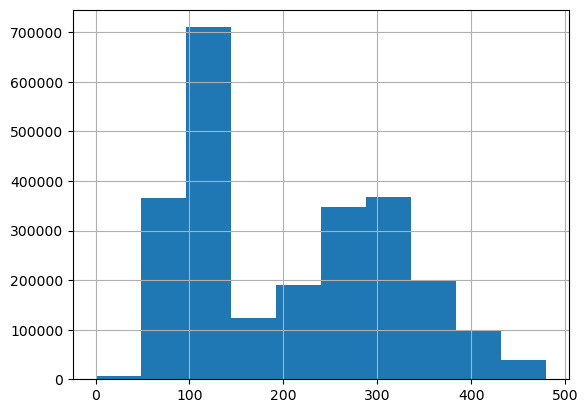

In [211]:
test_burger_df[test_burger_df['ownareaall_sqm'] < 500]['ownareaall_sqm'].hist()

In [204]:
burger_df.columns

Index(['customer_id', 'date_diff_post', 'buy_post', 'group_name', 'revenue',
       'startdatetime', 'dish_name', 'ownareaall_sqm', 'format_name'],
      dtype='object')

In [6]:
# Загружаем группы продуктов
menu_df = pd.read_excel('datasets/Menu_v2.xlsx')
menu_df.shape

(1049, 2)

In [7]:
# Период за который предоставлены данные
burger_df['startdatetime'].min(), burger_df['startdatetime'].max()

(Timestamp('2022-09-02 00:00:39'), Timestamp('2023-08-01 23:57:46'))

In [8]:
# Период за который предоставлены данные в тесте
test_burger_df['startdatetime'].min(), test_burger_df['startdatetime'].max()

(Timestamp('2022-09-02 00:04:00'), Timestamp('2023-08-01 23:31:03'))

In [9]:
# Проверка что в тестовых данных есть все уникальные места которые есть в обучающей выборке
set(map(tuple,test_burger_df[['format_name', 'ownareaall_sqm']].values.tolist())) - set(map(tuple,burger_df[['format_name', 'ownareaall_sqm']].values.tolist()))

set()

In [10]:
# Объединяем тест и трайн в один датасет для общей обработки
test_burger_df['buy_post'] = np.nan
test_burger_df['date_diff_post'] = np.nan
union_burger_df = pd.concat([burger_df, test_burger_df])
union_burger_df.shape

(14627418, 9)

In [11]:
# Добавляем категории продуктов
union_burger_df = union_burger_df.merge(menu_df, on='dish_name')
union_burger_df.shape

(14627418, 10)

In [12]:
# Различить одну кафе от другой вероятно можно только по уникальности пары: 'format_name', 'ownareaall_sqm'
place_df = union_burger_df[['format_name', 'ownareaall_sqm']].drop_duplicates().sort_values(by='format_name').reset_index().rename(columns={'index':'place_id'})
place_df.shape

(692, 3)

In [13]:
# Заменяем нулевые площади на схожие, но не путая ИД мест
place_df['correct_ownareaall_sqm'] = place_df['ownareaall_sqm']
place_df.loc[(place_df['format_name'] == 'Фудкорт без туалета')&(place_df['ownareaall_sqm'] == 0), 'correct_ownareaall_sqm'] = place_df[place_df['format_name'] == 'Фудкорт без туалета']['ownareaall_sqm'].median()
place_df.loc[(place_df['format_name'] == 'Отдельно стоящий с внешней зоной')&(place_df['ownareaall_sqm'] == 0), 'correct_ownareaall_sqm'] = place_df[place_df['format_name'] == 'Отдельно стоящий с внешней зоной']['ownareaall_sqm'].median()

In [14]:
# Заносим в общий датасет ид места
union_burger_df = union_burger_df.merge(place_df, on=['format_name', 'ownareaall_sqm'])
union_burger_df.shape

(14627418, 12)

In [15]:
union_burger_df.head(3)

,customer_id,date_diff_post,buy_post,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,dish_cat,place_id,correct_ownareaall_sqm
0,29891,9.0,1.0,train,69.99,2022-12-05 12:03:58,Кинг Фри станд,300.0,Отдельно стоящий без внешней зоны,Фри,0,300.0
1,197671,24.0,1.0,train,1.00,2022-09-25 16:12:58,Кинг Фри станд,300.0,Отдельно стоящий без внешней зоны,Фри,0,300.0
2,199749,NaN,0.0,train,94.99,2023-04-22 13:47:35,Кинг Фри станд,300.0,Отдельно стоящий без внешней зоны,Фри,0,300.0


### Формирование фич
Будем использовать бустинги  
Одна запись это 1 клиент  
Все данные по покупкам превращаем в фичи  

In [16]:
# burger_df[burger_df['customer_id'] == 29891]

In [17]:
# Раскладываем даты по возможным начениям
union_burger_df['date'] = union_burger_df['startdatetime'].dt.date
union_burger_df['date'] = pd.to_datetime(union_burger_df['date'])
union_burger_df['year'] = union_burger_df['startdatetime'].dt.year
union_burger_df['month'] = union_burger_df['startdatetime'].dt.month
union_burger_df['day'] = union_burger_df['startdatetime'].dt.day
union_burger_df['day_of_week'] = union_burger_df['startdatetime'].dt.day_of_week
union_burger_df['day_of_year'] = union_burger_df['startdatetime'].dt.day_of_year
union_burger_df['days_in_month'] = union_burger_df['startdatetime'].dt.days_in_month
union_burger_df['quarter'] = union_burger_df['startdatetime'].dt.quarter
union_burger_df['week'] = union_burger_df['startdatetime'].dt.week
union_burger_df['hour'] = union_burger_df['startdatetime'].dt.hour

# Для группировки данных по дням определяем начальную дату и сколько прошло дней с этого момента
date_2022 = datetime.strptime("2022-01-01", "%Y-%m-%d", ).replace(tzinfo=None)
union_burger_df['day_count'] = ((union_burger_df['startdatetime'] - date_2022) / np.timedelta64(1, 'D')).astype(int)
# Для группировки данных по три часа также устанавливаем для каждой значения группу
union_burger_df['hour_count'] = ((union_burger_df['startdatetime'] - date_2022) / np.timedelta64(3, 'h')).astype(int)

C:\Users\Profit77\AppData\Local\Temp\ipykernel_1952\3234485552.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  union_burger_df['week'] = union_burger_df['startdatetime'].dt.week


In [18]:
# Определяем время дня: утро/день/вечер
def time_of_day(row):
    hour = row.hour
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'day'
    else:
        return 'evening'

union_burger_df['times_of_day'] = union_burger_df['startdatetime'].apply(time_of_day)

In [19]:
# one_hot_encoding = pd.get_dummies(burger_df['times_of_day'], prefix='time_')
# df_concat = pd.concat([df_concat, one_hot_encoding], axis=1)
# df_concat

In [20]:
# Создаем датафрейм для итоговых агрегатов по клиентам
customer_df = pd.DataFrame()

In [21]:
# pd.DataFrame(position_by_day_df).reset_index().groupby(by=['customer_id'])['dish_name'].mean()
# burger_df.groupby(by=['customer_id'])['dish_name'].mean()

In [22]:
# Сколько позиций в заданный период времени
def calc_position_by_time(df, period_column:str='day_count'):
    position_by_time = df.groupby(by=['customer_id', period_column])['dish_name'].count()
    mean_position_by_time = pd.DataFrame(position_by_time).reset_index().groupby(by=['customer_id'])['dish_name'].mean()
    mean_position_by_time = pd.DataFrame(mean_position_by_time).reset_index()
    mean_position_by_time = mean_position_by_time.rename(columns={'dish_name':f'mean_position_by_{period_column}'}).set_index('customer_id')
    return mean_position_by_time


In [23]:
# Сколько позиций в день
mean_position_by_day = calc_position_by_time(union_burger_df, period_column='day_count')
# Сколько позиций в три часа
mean_position_by_3hour = calc_position_by_time(union_burger_df, period_column='hour_count')
# Сколько позиций в час
mean_position_by_hour = calc_position_by_time(union_burger_df, period_column='hour')

customer_df = pd.concat([customer_df, mean_position_by_day, mean_position_by_3hour, mean_position_by_hour], axis=1)
customer_df.shape

(612334, 3)

In [24]:
# Формируем сгруппированый датафрейм по посещениям за каждый день по каждому клиенту
visited_days_df = union_burger_df.groupby(by=['customer_id', 'date'])['dish_name'].count()
visited_days_df = pd.DataFrame(visited_days_df).reset_index()

In [25]:
def calc_stat_visited_by_period(period:str='1D'):
    calc_visited_df = pd.DataFrame([])
    select_group_visited = visited_days_df.set_index('date').groupby('customer_id')['customer_id'].rolling(period).count().groupby(by=['customer_id'])
    # calc_visited_df[f'count_visited_by_{period}'] = select_group_visited.count()
    calc_visited_df[f'max_visited_by_{period}'] = select_group_visited.max()
    calc_visited_df[f'mean_visited_by_{period}'] = select_group_visited.mean()
    return calc_visited_df

In [26]:
%%time
union_visited_df = pd.DataFrame(visited_days_df.set_index('date').groupby('customer_id')['customer_id'].rolling('1D').count().groupby(by=['customer_id']).count().rename('count_visited'))
for period in tqdm(['2D', '3D', '5D', '7D', '14D', '21D', '30D', '50D', '60D', '100D', '150D', '200D']):
    print(f'calc period: {period}')
    visited_df = calc_stat_visited_by_period(period=period)
    union_visited_df = pd.concat([union_visited_df, visited_df], axis=1)
union_visited_df.shape

  0%|          | 0/12 [00:00<?, ?it/s]

calc period: 2D


  8%|▊         | 1/12 [00:12<02:12, 12.04s/it]

calc period: 3D


 17%|█▋        | 2/12 [00:23<01:59, 11.94s/it]

calc period: 5D


 25%|██▌       | 3/12 [00:35<01:47, 11.93s/it]

calc period: 7D


 33%|███▎      | 4/12 [00:47<01:35, 11.92s/it]

calc period: 14D


 42%|████▏     | 5/12 [00:59<01:23, 11.92s/it]

calc period: 21D


 50%|█████     | 6/12 [01:11<01:11, 11.89s/it]

calc period: 30D


 58%|█████▊    | 7/12 [01:23<00:59, 11.89s/it]

calc period: 50D


 67%|██████▋   | 8/12 [01:35<00:47, 11.89s/it]

calc period: 60D


 75%|███████▌  | 9/12 [01:47<00:35, 11.90s/it]

calc period: 100D


 83%|████████▎ | 10/12 [01:59<00:23, 11.89s/it]

calc period: 150D


 92%|█████████▏| 11/12 [02:10<00:11, 11.89s/it]

calc period: 200D


100%|██████████| 12/12 [02:22<00:00, 11.90s/it]

CPU times: total: 2min 34s
Wall time: 2min 34s


(612334, 25)

In [27]:
customer_df = pd.concat([customer_df, union_visited_df], axis=1)
customer_df.shape

(612334, 28)

In [28]:
union_burger_df.shape

(14627418, 25)

In [29]:
# Временные фичи

In [30]:
# В качестве общих признаков по дате используем последние записи по сгруппированным по клиенту данным
last_row_burger_columns = ['format_name', 'year', 'month', 'day', 
                         'day_count', 'day_of_week', 'day_of_year', 
                         'days_in_month', 'quarter', 'week', 
                         'hour_count', 'hour', 'date', 'correct_ownareaall_sqm']
last_row_df = union_burger_df[['customer_id', 'startdatetime'] + last_row_burger_columns].sort_values(by='startdatetime').groupby(by=['customer_id'])[last_row_burger_columns].last()
customer_df = pd.concat([customer_df, last_row_df], axis=1)
customer_df.shape

(612334, 42)

In [31]:
# Рабочий день или выходной/праздничный
prazdniki = ['2022-11-04', '2022-12-31', '2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', 
             '2023-01-06', '2023-02-23', '2023-02-24', '2023-03-08', '2023-05-01','2023-05-08', '2023-05-09', '2023-06-12',]
# union_burger_df['is_work_day'] = np.where(( (union_burger_df['date'].isin(prazdniki)) | (union_burger_df['day_of_week'] >=5)), 0, 1)
union_burger_df['type_day'] = np.where(( (union_burger_df['date'].isin(prazdniki)) | (union_burger_df['day_of_week'] >=5)), 'holiday', 'workday')

In [34]:
# %%time
#if need also category c with no values of 'one'
# union_burger_df.groupby(['customer_id', 'date'])['times_of_day'].apply(lambda x: (x=='morning').sum()).reset_index(name='count')
# print (df11)

In [48]:
union_burger_df[['customer_id', 'date', 'times_of_day']].drop_duplicates().shape


(14627418, 3)

In [49]:
%%time
# Считаем посещения по клиентам по временам суток
visited_time_of_day_df = union_burger_df[['customer_id', 'date', 'times_of_day']].drop_duplicates().groupby(by=['customer_id']).agg(
    # Кол-во посещений всего
    count_times_of_visited = ('times_of_day', len),
    # Кол-во посещений утром
    count_times_of_morning = ('times_of_day', lambda x: x.eq('morning').sum()),
    # Кол-во посещений днем
    count_times_of_day = ('times_of_day', lambda x: x.eq('day').sum()),
    # Кол-во посещений вечером
    count_times_of_evening = ('times_of_day', lambda x: x.eq('evening').sum()),
)
visited_time_of_day_df.shape

CPU times: total: 2min 14s
Wall time: 2min 14s


(612334, 4)

In [53]:
# Считаем долю посещений по временам суток
visited_time_of_day_df['prc_morning_visited'] = visited_time_of_day_df['count_times_of_morning']/visited_time_of_day_df['count_times_of_visited']
visited_time_of_day_df['prc_day_time_visited'] = visited_time_of_day_df['count_times_of_day']/visited_time_of_day_df['count_times_of_visited']
visited_time_of_day_df['prc_evening_visited'] = visited_time_of_day_df['count_times_of_evening']/visited_time_of_day_df['count_times_of_visited']

customer_df = pd.concat([customer_df, visited_time_of_day_df], axis=1)
customer_df.shape

(612334, 49)

In [55]:
%%time
# Считаем посещения по клиентам из разряда один день одно посещение
visited_weekday_df = union_burger_df[['customer_id', 'date', 'type_day']].drop_duplicates().groupby(by=['customer_id']).agg(
    # Кол-во посещений всего
    count_visited_by_day = ('date', len),
    # Кол-во посещений в будни    
    count_visited_workday = ('type_day', lambda x: x.eq('workday').sum()),
    # Кол-во посещений в выходные
    count_visited_holiday = ('type_day', lambda x: x.eq('holiday').sum()),
)
visited_weekday_df.shape

CPU times: total: 1min 37s
Wall time: 1min 37s


(612334, 3)

In [58]:
# Считаем долю по типу будни/выходные
visited_weekday_df['prc_visited_workday'] = visited_weekday_df['count_visited_workday']/visited_weekday_df['count_visited_by_day']
visited_weekday_df['prc_visited_holiday'] = visited_weekday_df['count_visited_holiday']/visited_weekday_df['count_visited_by_day']

customer_df = pd.concat([customer_df, visited_weekday_df], axis=1)
customer_df.shape

(612334, 54)

In [59]:
%%time
# Считаем временные агрегаты по клиентам
count_dish_cat_df = union_burger_df.groupby(by=['customer_id']).agg(
    # Кол-во позиций всего
    count_revenue = ('revenue', len),
    # Кол-во позиций типа Категория Бургер
    count_dish_cat_burger = ('dish_cat', lambda x: x.eq('Бургер').sum()),
    # Кол-во позиций типа Категория Напитки
    count_dish_cat_drink = ('dish_cat', lambda x: x.eq('Напитки').sum()),
    # Кол-во позиций типа Категория Воппер
    count_dish_cat_vopper = ('dish_cat', lambda x: x.eq('Воппер').sum()),
    # Кол-во позиций типа Категория Кофе
    count_dish_cat_koffe = ('dish_cat', lambda x: x.eq('Кофе').sum()),
    # Кол-во позиций типа Категория Фри
    count_dish_cat_fri = ('dish_cat', lambda x: x.eq('Фри').sum()),
    # Кол-во позиций типа Категория наггетсы
    count_dish_cat_naggets = ('dish_cat', lambda x: x.eq('наггетсы').sum()),
    # Кол-во позиций типа Категория Десерты
    count_dish_cat_desert = ('dish_cat', lambda x: x.eq('Десерты').sum()),
    # Кол-во позиций типа Категория Ролл
    count_dish_cat_roll = ('dish_cat', lambda x: x.eq('Ролл').sum()),
    # Кол-во позиций типа Категория чипсы
    count_dish_cat_chips = ('dish_cat', lambda x: x.eq('чипсы').sum()),
    # Кол-во позиций типа Категория Прочее
    count_dish_cat_other = ('dish_cat', lambda x: x.eq('Прочее').sum()),
    # Кол-во позиций типа Категория соус
    count_dish_cat_sous = ('dish_cat', lambda x: x.eq('соус').sum()),
    # Кол-во позиций типа Категория Пиво
    count_dish_cat_beer = ('dish_cat', lambda x: x.eq('Пиво').sum()),
    # Кол-во позиций типа Категория Шейк
    count_dish_cat_sheik = ('dish_cat', lambda x: x.eq('Шейк').sum()),
    # Кол-во позиций типа Категория Креветки
    count_dish_cat_krevetki = ('dish_cat', lambda x: x.eq('Креветки').sum()),
    # Кол-во позиций типа Категория Салфетка
    count_dish_cat_paper = ('dish_cat', lambda x: x.eq('Салфетка').sum()),
    # Кол-во позиций типа Категория Салат
    count_dish_cat_salat = ('dish_cat', lambda x: x.eq('Салат').sum()),
    # Кол-во позиций типа Категория Чай
    count_dish_cat_tie = ('dish_cat', lambda x: x.eq('Чай').sum()),
)
count_dish_cat_df.shape

CPU times: total: 12min 30s
Wall time: 12min 30s


In [63]:
# Рассчитываем долю типов продуктов
count_dish_cat_df['prc_dish_cat_burger'] = count_dish_cat_df['count_dish_cat_burger']/count_dish_cat_df['count_revenue']
count_dish_cat_df['prc_dish_cat_drink'] = count_dish_cat_df['count_dish_cat_drink']/count_dish_cat_df['count_revenue']
count_dish_cat_df['prc_dish_cat_vopper'] = count_dish_cat_df['count_dish_cat_vopper']/count_dish_cat_df['count_revenue']
count_dish_cat_df['prc_dish_cat_koffe'] = count_dish_cat_df['count_dish_cat_koffe']/count_dish_cat_df['count_revenue']
count_dish_cat_df['prc_dish_cat_fri'] = count_dish_cat_df['count_dish_cat_fri']/count_dish_cat_df['count_revenue']
count_dish_cat_df['prc_dish_cat_naggets'] = count_dish_cat_df['count_dish_cat_naggets']/count_dish_cat_df['count_revenue']
count_dish_cat_df['prc_dish_cat_desert'] = count_dish_cat_df['count_dish_cat_desert']/count_dish_cat_df['count_revenue']
count_dish_cat_df['prc_dish_cat_roll'] = count_dish_cat_df['count_dish_cat_roll']/count_dish_cat_df['count_revenue']
count_dish_cat_df['prc_dish_cat_chips'] = count_dish_cat_df['count_dish_cat_chips']/count_dish_cat_df['count_revenue']
count_dish_cat_df['prc_dish_cat_other'] = count_dish_cat_df['count_dish_cat_other']/count_dish_cat_df['count_revenue']
count_dish_cat_df['prc_dish_cat_sous'] = count_dish_cat_df['count_dish_cat_sous']/count_dish_cat_df['count_revenue']
count_dish_cat_df['prc_dish_cat_beer'] = count_dish_cat_df['count_dish_cat_beer']/count_dish_cat_df['count_revenue']
count_dish_cat_df['prc_dish_cat_sheik'] = count_dish_cat_df['count_dish_cat_sheik']/count_dish_cat_df['count_revenue']
count_dish_cat_df['prc_dish_cat_krevetki'] = count_dish_cat_df['count_dish_cat_krevetki']/count_dish_cat_df['count_revenue']
count_dish_cat_df['prc_dish_cat_paper'] = count_dish_cat_df['count_dish_cat_paper']/count_dish_cat_df['count_revenue']
count_dish_cat_df['prc_dish_cat_salat'] = count_dish_cat_df['count_dish_cat_salat']/count_dish_cat_df['count_revenue']
count_dish_cat_df['prc_dish_cat_tie'] = count_dish_cat_df['count_dish_cat_tie']/count_dish_cat_df['count_revenue']

count_dish_cat_df.shape

(612334, 35)

In [64]:
customer_df = pd.concat([customer_df, count_dish_cat_df], axis=1)
customer_df.shape

(612334, 89)

In [65]:
# Определяем таргеты для клиента, просто последня запись по сгруппированным по клиенту данным
target_df = union_burger_df.groupby(by=['customer_id'])[['buy_post', 'date_diff_post']].last()
customer_df = pd.concat([customer_df, target_df], axis=1)
customer_df.shape

(612334, 91)

In [66]:
# save_customer_df = customer_df.copy()

In [69]:
# Сколько уникальных мест посещал клиент или только в один ходит
# count_uniq_place_df = burger_df.groupby(by=['customer_id']).agg({"place_id": pd.Series.nunique}).rename(columns={'place_id': 'count_uniq_place'})
count_uniq_place_df = union_burger_df.groupby(by=['customer_id']).agg(count_uniq_place=("place_id", pd.Series.nunique))
customer_df = pd.concat([customer_df, count_uniq_place_df], axis=1)
customer_df.shape

(612334, 92)

In [70]:
# Кол-во положительных клиентов (оставшихся) по трейну
count_good_customers_df = union_burger_df.groupby(by=['place_id', 'customer_id']).agg(count_good_customers = ('buy_post', lambda x: x.eq(1).sum())).clip(upper=1).groupby(by=['place_id']).sum()
count_good_customers_df.shape

(692, 1)

In [71]:
%%time
# Считаем агрегаты для опредлеенного места
place_features_df = union_burger_df.groupby(by=['place_id']).agg(
    # Кол-во уникальных клиентов
    count_uniq_customers = ('customer_id', pd.Series.nunique),
    # Сумма чека по всем продуктам
    sum_revenue = ('revenue', np.sum),
    # Средняя сумма по каждой позиции
    mean_one_revenue = ('revenue', np.mean),
    # Медиана сумма по каждой позиции
    median_one_revenue = ('revenue', np.median),
    # Кол-во позиций всего
    count_revenue = ('revenue', len),
    # Минимальное число дней, через сколько приходят клиенты
    min_diff_post = ('date_diff_post', np.min),
    # Медианное число дней, через сколько приходят клиенты
    median_diff_post = ('date_diff_post', np.median),
    # Максимальное число дней, через сколько приходят клиенты
    max_diff_post = ('date_diff_post', np.max),
)
place_features_df.shape

(692, 8)

In [72]:
# Добавляем Кол-во положительных клиентов по месту
place_features_df = place_features_df.merge(count_good_customers_df, on='place_id')

In [73]:
# Рассчитываем доп характеристики по месту 
place_features_df['prc_good_customers'] = place_features_df['count_good_customers']/place_features_df['count_uniq_customers']
place_features_df['mean_revenue_by_client'] = place_features_df['sum_revenue']/place_features_df['count_uniq_customers']
place_features_df['mean_revenue'] = place_features_df['sum_revenue']/place_features_df['count_revenue']

In [74]:
# Определяем приоритетное кафе у клиента
client_pop_place_df = union_burger_df.groupby(by=['customer_id', 'place_id']).agg(count_visit=('buy_post', len))
client_pop_place_df = client_pop_place_df.reset_index()

# Ищем какие места клиент посещал чаще других, в случаи совпадений берем последний
client_pop_place_df = client_pop_place_df[client_pop_place_df['count_visit'] == client_pop_place_df.groupby(['customer_id'])['count_visit'].transform(max)]
client_pop_place_df = client_pop_place_df.groupby(by=['customer_id']).last()
client_pop_place_df = client_pop_place_df.rename(columns={'place_id': 'pop_place_id', 'count_visit': 'count_visit_pop_place'})
client_pop_place_df.shape

(612334, 2)

In [76]:
# save_customer_df = customer_df.copy()
# customer_df = save_customer_df.copy()

In [75]:
customer_df = customer_df.merge(client_pop_place_df, on='customer_id')
customer_df.shape

(612334, 94)

In [77]:
customer_df = customer_df.reset_index().merge(place_features_df, left_on='pop_place_id', right_on='place_id')
customer_df = customer_df.set_index('customer_id')
customer_df.shape

(612334, 106)

In [269]:
# df_grouped = tmp_df.groupby(['customer_id', 'place_id']).agg({'count_visit':'max'})
# # df_grouped = df_grouped.reset_index()
# # df_grouped = df_grouped.rename(columns={'count_visit':'count_max'})
# # tmp_df_2 = pd.merge(tmp_df, df_grouped, how='left', on=['customer_id', 'place_id'])
# # # tmp_df_2 = tmp_df[tmp_df['count_visit'] == tmp_df['count_max']]
# # tmp_df_2
# df_grouped

In [270]:
# tmp_df[tmp_df['customer_id'] == 29891].groupby(['customer_id', 'place_id'])["count_visit"].idxmax()
# # tmp_df.groupby(['customer_id', 'place_id'])["count_visit"].idxmax()

In [271]:
# tmp_df.loc[tmp_df.groupby(['customer_id', 'place_id'])["count_visit"].idxmax()]

In [272]:
# # tmp_df2 = tmp_df.sort_values('count_visit').drop_duplicates(['customer_id', 'place_id'], keep='last')
# tmp_df2 = tmp_df.sort_values('count_visit').groupby(['customer_id', 'place_id']).tail(1)

In [384]:
# burger_df.groupby(['customer_id','month']).size().reset_index(name='freq')

In [99]:
# Частота посещения людьми кафе в определенный день
agg_func_math = {
    'day': ['mean', 'median', 'min', 'max'],
    'month': ['mean', 'median', 'min', 'max']
}
#burger_df.groupby(by=['customer_id', period_column])['dish_name'].count()
burger_df.groupby(by=['customer_id']).agg(agg_func_math).head(7)

day                     month               
                  mean median min max       mean median min max
customer_id                                                    
29891        18.911765   21.5   1  31   8.794118   12.0   1  12
30477        14.721311   15.0   1  31  10.590164   11.0  10  11
31426        14.604651   14.0   1  31   5.906977    6.0   5   7
44491         9.600000   10.0   8  11   6.300000    6.0   6   7
44939        16.720000   17.0  10  25  12.000000   12.0  12  12
45006        17.368421   18.0   7  25   5.157895    5.0   5   6
45038        12.722222    8.0   8  19   3.555556    4.0   3   4

In [100]:
# Определеяем характеристики мест

In [31]:
burger_df.shape

(12129384, 22)

# Модели

In [78]:
# Вывод графика feature importance
def plot_feature_importance(importance, names, model_name="", top_n=-1, skip_columns=[]):
    """Функция вывода feature importance
        :importance - массив важности фичей, полученный от модели
        :names - массив названий фичей
        :model_name - название модели
        :top_n - кол-во выводимых фичей
        :skip_columns: какие фичи пропустить, такое может понадобиться чтобы временно убрать 
                        из отображаемых горячие фичи, и изучить менее сильные
        :return - fi_df - feature importance датафрейм
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df[~fi_df['feature_names'].isin(skip_columns)]
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
    if top_n != -1:
        plt.title(f"{model_name} FEATURE IMPORTANCE (Top: {top_n})")
    else:
        plt.title(f"{model_name} FEATURE IMPORTANCE")
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return fi_df

In [79]:
# Вывод графика ROC-AUC
def plot_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_pred)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_pred)

    plt.figure(figsize=(10, 3))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.4f)' % roc_auc, alpha=0.5)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    return roc_auc

In [84]:
train_customers_idx = union_burger_df[union_burger_df['group_name'] == 'train']['customer_id'].unique()
test_customers_idx = union_burger_df[union_burger_df['group_name'] == 'test']['customer_id'].unique()
train_customers_idx.shape, test_customers_idx.shape

((500000,), (112334,))

In [86]:
customer_df = customer_df.reset_index()
train_data_df = customer_df[customer_df['customer_id'].isin(train_customers_idx)]
test_data_df = customer_df[customer_df['customer_id'].isin(test_customers_idx)]

train_data_df.shape, test_data_df.shape

((500000, 107), (112334, 107))

In [200]:
# customer_df.merge(union_burger_df[['group_name', 'customer_id']], on='customer_id', how='left').shape


In [201]:
save_customer_df = customer_df.copy()
save_customer_df.loc[save_customer_df['customer_id'].isin(train_customers_idx), 'group_name'] = 'train'
save_customer_df.loc[~save_customer_df['customer_id'].isin(train_customers_idx), 'group_name'] = 'test'
save_customer_df.shape

(612334, 108)

In [203]:
save_customer_df.to_parquet('save_customer_df.parquet')

In [91]:
target_columns = ['buy_post', 'date_diff_post']
id_column = ['customer_id']
# ignore_columns = ['ownareaall_sqm'] + id_column
ignore_columns = ['date'] + id_column
categorical_columns = ['format_name', 'pop_place_id']
numeric_columns = list(set(train_data_df.columns) - set(categorical_columns + ignore_columns + target_columns))
feature_columns = numeric_columns + categorical_columns + ignore_columns

len(numeric_columns), len(categorical_columns), len(feature_columns)

(101, 2, 105)

# Модель оттока (Классификация)

In [628]:
# # Подключаем дополнительные модели для формирования ансамбля
# from sklearn.neural_network import MLPClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
# from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from xgboost import XGBClassifier, XGBRegressor
# from lightgbm import LGBMClassifier, LGBMRegressor 
# from catboost import CatBoostClassifier

# from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsembleClassifier
# from imblearn.ensemble import RUSBoostClassifier, BalancedRandomForestClassifier

# from sklearn.metrics import roc_auc_score, roc_curve, f1_score, classification_report, precision_score, recall_score, f1_score

In [121]:
target_column = 'buy_post'
cls_target_column = 'buy_post'

In [122]:
train_df, val_df = train_test_split(train_data_df, test_size=0.1, shuffle=True, random_state=53, stratify=train_data_df[cls_target_column]) 
val_df, test_df = train_test_split(val_df, test_size=0.5, shuffle=True, random_state=53, stratify=val_df[cls_target_column]) 

assert len(set(train_df[id_column].values.flatten()) & set(test_df[id_column].values.flatten())) == 0, "Лик данных между train и test"
assert len(set(val_df[id_column].values.flatten()) & set(test_df[id_column].values.flatten())) == 0, "Лик данных между val и test"
assert len(set(train_df[id_column].values.flatten()) & set(val_df[id_column].values.flatten())) == 0, "Лик данных между train и val"

train_df.shape, val_df.shape, test_df.shape

((450000, 107), (25000, 107), (25000, 107))

In [123]:
X_train = train_df[feature_columns]
y_train = train_df[cls_target_column]

X_val = val_df[feature_columns]
y_val = val_df[cls_target_column]

X_test = test_df[feature_columns]
y_test = test_df[cls_target_column]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((450000, 105), (450000,), (25000, 105), (25000,), (25000, 105), (25000,))

In [124]:
# Расчет дисбалнса классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0.0: 1.7742380633205852, 1.0: 0.6961956773983942}

In [633]:
# scale_pos_weight = len(data_df[data_df[target_column]==0])/len(data_df[data_df[target_column]==1])
# prc_weight = min(y_train.value_counts())/max(y_train.value_counts())
# classifiers = [
#                # ['CatBoost :', CatBoostClassifier(class_weights=class_weights, cat_features=categorical_columns, verbose=False, random_state=53)],
#                # ['BalancedBaggingClassifier :', BalancedBaggingClassifier(n_estimators=200, max_samples=prc_weight, random_state=53)],
#                ['EasyEnsembleClassifier :', EasyEnsembleClassifier(random_state=53, n_jobs=-1)],
#                ['CatBoost :', CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, verbose=False, class_weights=class_weights, random_state=53, cat_features=categorical_columns, ignored_features=ignore_columns)],
#                ['ExtraTreesClassifier :', ExtraTreesClassifier(class_weight=class_weights, random_state=53, n_jobs=-1)],
#                ['RandomForest :', RandomForestClassifier(n_estimators=200, class_weight=class_weights, random_state=53, n_jobs=-1)],
#                # ['AdaBoostClassifier :', AdaBoostClassifier(random_state=53)],
#                # ['GradientBoostingClassifier: ', GradientBoostingClassifier(random_state=53)],
#                ['XGB :', XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=53, n_jobs=-1)],
#                ['LGBM :', LGBMClassifier(scale_pos_weight=scale_pos_weight, verbose=-1, random_state=53, n_jobs=-1)],
               
# ]

In [517]:
# 'date', 'sum_revenue', 'format_name'
# X_train = train_df[feature_columns]
# mini_feature_columns

In [634]:
# full_X_train = pd.concat([X_train, X_val])
# full_y_train = pd.concat([y_train, y_val])

# full_X_train.shape, full_y_train.shape

In [555]:
def metrics_classifie(y_test, y_pred,model, X_test, name='model'):
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'{name} - Precision: {precision:.2f} | Recall: {recall:.2} | F1-score: {f1:.2} | ROCAUC: {roc_auc_score(y_true=y_test, y_score=model.predict_proba(X_test)[:,1])}')

In [534]:
# ans_X_train['format_name']

In [552]:
# m = EasyEnsembleClassifier(random_state=53, verbose=1, n_jobs=-1)
# m.fit(full_X_train[numeric_columns], full_y_train)  # Предполагается, что X_train и y_train подготовлены

In [636]:
# %%time
# # Обучаем k моделей
# proba_predictions = []

# for name, model in tqdm(classifiers):
#     print(name)
#     if name == 'CatBoost :':
#         ans_X_train = full_X_train.copy()
#         ans_X_test = X_test.copy()
#     else:
#         ans_X_train = full_X_train[numeric_columns].copy()
#         ans_X_test = X_test[numeric_columns].copy()
        
#     model.fit(ans_X_train, full_y_train)  # Предполагается, что X_train и y_train подготовлены
#     y_pred = model.predict(ans_X_test)
#     metrics_classifie(y_test, y_pred, model, ans_X_test, name)
#     proba_predictions.append(model.predict_proba(ans_X_test))

#     print(ans_X_train.shape, full_y_train.shape, y_test.shape, ans_X_test.shape)

In [637]:
# # Усреднение вероятностей
# average_proba_predict = np.mean(np.array(proba_predictions), axis=0)
# print(f'ROCAUC: {roc_auc_score(y_true=y_test, y_score=average_proba_predict[:,1])}')

In [638]:
# # y_pred = model_clf.predict(X_test)
# print(classification_report(y_test, y_pred=[1 if pred >= 0.5 else 0 for pred in average_proba_predict[:,1]]))

In [639]:
# # Строим график ROC-AUC
# roc_auc = plot_roc_auc(y_true=y_test, y_pred=average_proba_predict[:,1])
# print(classification_report(y_true=y_test, y_pred=[1 if pred >= 0.5 else 0 for pred in average_proba_predict[:,1]]))
# roc_auc

In [100]:
train_data_df.shape

(500000, 107)

In [193]:
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=400, class_weights=class_weights, random_state=53, cat_features=categorical_columns, ignored_features=ignore_columns)
model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=1500, 
                               scale_pos_weight=0.3, task_type="GPU",
                               #class_weights=class_weights, 
                               random_state=53, cat_features=categorical_columns, ignored_features=ignore_columns)
model_clf.fit(train_data_df[feature_columns], train_data_df[target_column], plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


In [187]:
val_model_clf = CatBoostClassifier(eval_metric='AUC', early_stopping_rounds=200, iterations=3000, 
                                   scale_pos_weight=0.3, task_type="GPU",
                                   #class_weights=class_weights, 
                                   random_state=42, cat_features=categorical_columns, ignored_features=ignore_columns, task_type="GPU")

# val_model_clf = CatBoostClassifier(eval_metric="F1", early_stopping_rounds=50, iterations=1000, class_weights=class_weights, random_state=42, cat_features=categorical_columns, ignored_features=ignore_columns)
# val_model_clf = CatBoostClassifier(eval_metric='TotalF1:average=Macro;use_weights=False', early_stopping_rounds=50, iterations=1000, class_weights=class_weights, random_state=42, cat_features=categorical_columns, ignored_features=ignore_columns)
# 
val_model_clf.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


In [188]:
# Вычисляем F1-меру 
best_f1_scores = f1_score(y_test, val_model_clf.predict(X_test), labels=[0], average='weighted')
 
proba_predictions = val_model_clf.predict_proba(X_test)[:, 1]
 
best_threshold = 0.5  # начальное значение порогаbest_f1_scores = 0 

thresholds = np.linspace(0, 1, num=1000)
#thresholds = pd.Series(proba_predictions).unique() 

for threshold in tqdm(thresholds): 
    predictions = (proba_predictions >= threshold).astype(int) 
    
    f1_scores = f1_score(y_test, predictions, labels=[0], average='weighted') 
    # f1_scores = f1_score(y_test, predictions, average='macro') 
    if f1_scores > best_f1_scores:        
        best_f1_scores = f1_scores 
        best_threshold = threshold
        print(f"F1-мера для класса 0: {f1}")
 
print(f"Лучший порог: {best_threshold}")
print(f"Максимальная f1:{best_f1_scores}") 
threshold = best_threshold

 44%|████▎     | 437/1000 [00:02<00:03, 144.48it/s]

F1-мера для класса 0: 0.5474878270640483
F1-мера для класса 0: 0.5474878270640483
F1-мера для класса 0: 0.5474878270640483
F1-мера для класса 0: 0.5474878270640483
F1-мера для класса 0: 0.5474878270640483
F1-мера для класса 0: 0.5474878270640483
F1-мера для класса 0: 0.5474878270640483
F1-мера для класса 0: 0.5474878270640483
F1-мера для класса 0: 0.5474878270640483
F1-мера для класса 0: 0.5474878270640483
F1-мера для класса 0: 0.5474878270640483
F1-мера для класса 0: 0.5474878270640483
F1-мера для класса 0: 0.5474878270640483
F1-мера для класса 0: 0.5474878270640483
F1-мера для класса 0: 0.5474878270640483
F1-мера для класса 0: 0.5474878270640483
F1-мера для класса 0: 0.5474878270640483


 47%|████▋     | 467/1000 [00:03<00:03, 138.99it/s]

F1-мера для класса 0: 0.5474878270640483


100%|██████████| 1000/1000 [00:06<00:00, 150.76it/s]

Лучший порог: 0.44744744744744747
Максимальная f1:0.551136068216087


In [141]:
threshold

0.5274527452745275

In [189]:
y_pred = val_model_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.41      0.82      0.55      7045
         1.0       0.88      0.53      0.66     17955

    accuracy                           0.61     25000
   macro avg       0.65      0.68      0.61     25000
weighted avg       0.75      0.61      0.63     25000



In [411]:
y_pred = model_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.73      0.55      7045
           1       0.86      0.63      0.73     17955

    accuracy                           0.66     25000
   macro avg       0.65      0.68      0.64     25000
weighted avg       0.74      0.66      0.68     25000



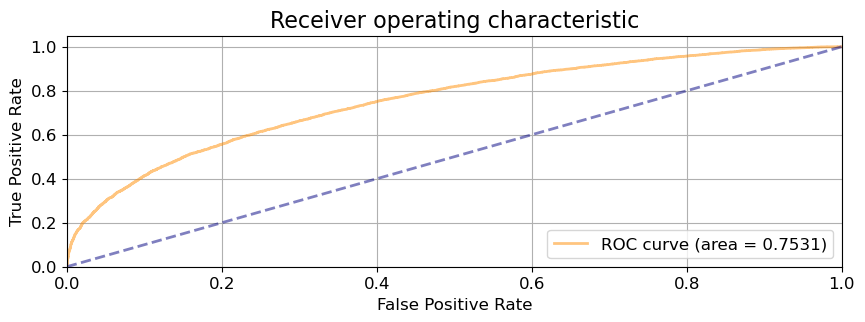

0.7530927389445936

In [134]:
# Для рассчета ROC-AUC на baseline моделе используем тестовые данные
y_pred = model_clf.predict_proba(X_test)[:,1]
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred)
roc_auc

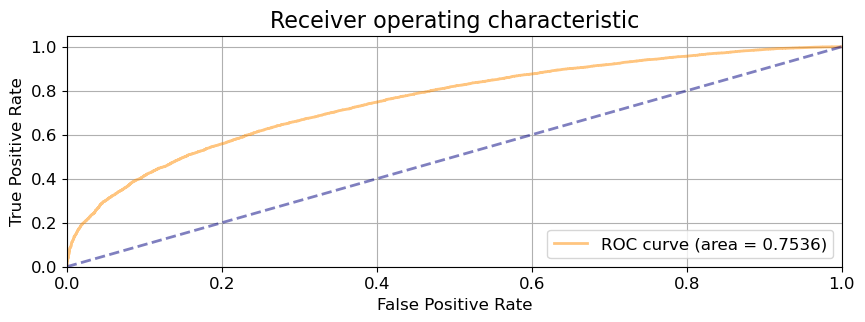

0.7536454415749175

In [190]:
# Для рассчета ROC-AUC на baseline моделе используем тестовые данные
y_pred = val_model_clf.predict_proba(X_test)[:,1]
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred)
roc_auc

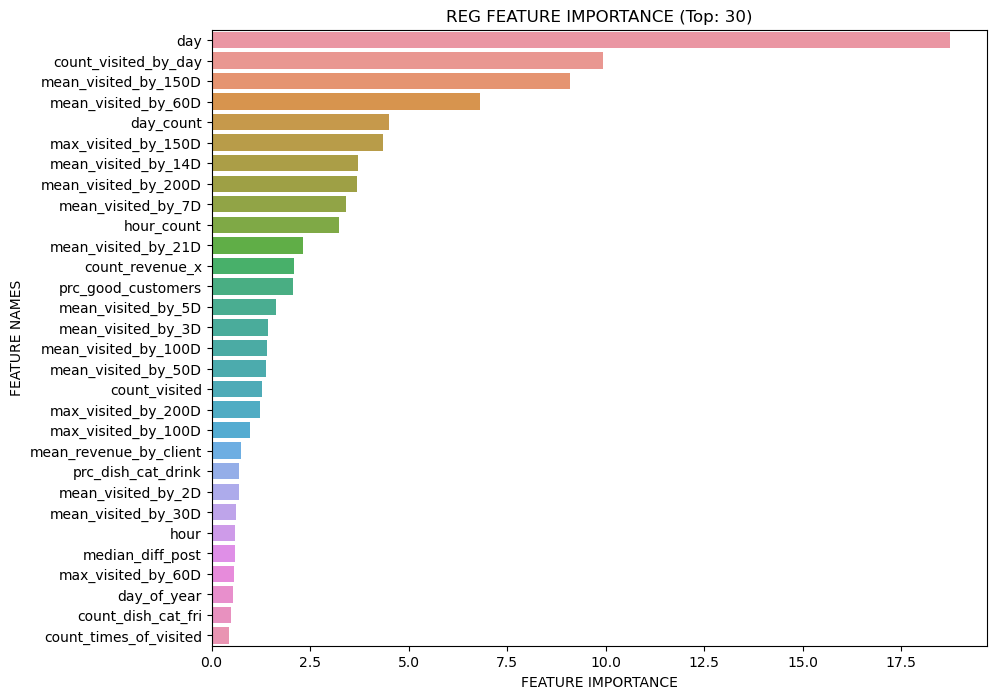

In [184]:
# Важность признаков
fi_df_model_clf = plot_feature_importance(val_model_clf.get_feature_importance(), X_test.columns, model_name='REG', top_n=30)  

# Модель посещений (Регрессия)

In [107]:
target_column = 'date_diff_post'

In [102]:
regression_data_df = train_data_df[train_data_df['buy_post'] == 1].copy()
regression_data_df.shape

(359095, 107)

In [ ]:
# regression_data_df.isna().sum()

In [103]:
train_df, val_df = train_test_split(regression_data_df, test_size=0.1, shuffle=True, random_state=53) 
val_df, test_df = train_test_split(val_df, test_size=0.5, shuffle=True, random_state=53) 

assert len(set(train_df[id_column].values.flatten()) & set(test_df[id_column].values.flatten())) == 0, "Лик данных между train и test"
assert len(set(val_df[id_column].values.flatten()) & set(test_df[id_column].values.flatten())) == 0, "Лик данных между val и test"
assert len(set(train_df[id_column].values.flatten()) & set(val_df[id_column].values.flatten())) == 0, "Лик данных между train и val"

train_df.shape, val_df.shape, test_df.shape

((323185, 107), (17955, 107), (17955, 107))

In [104]:
X_train = train_df[feature_columns]
y_train = train_df[target_column]

X_val = val_df[feature_columns]
y_val = val_df[target_column]

X_test = test_df[feature_columns]
y_test = test_df[target_column]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((323185, 105), (323185,), (17955, 105), (17955,), (17955, 105), (17955,))

In [ ]:
# full_X_train = pd.concat([X_train, X_val])
# full_y_train = pd.concat([y_train, y_val])

# full_X_train.shape, full_y_train.shape

In [ ]:
# regressors = [
#                ['CatBoost :', CatBoostRegressor(loss_function='RMSE', eval_metric="RMSE", early_stopping_rounds=50, iterations=1000, random_state=53, verbose=False, cat_features=categorical_columns, ignored_features=ignore_columns)],
#                ['ExtraTrees :', ExtraTreesRegressor(n_estimators=100, random_state=53, n_jobs=-1)],
#                ['RandomForest :', RandomForestRegressor(n_estimators=200, random_state=53, n_jobs=-1)],
#                ['XGB :', XGBRegressor(random_state=53, n_jobs=-1)],
#                ['LGBM :', LGBMRegressor (verbose=-1, random_state=53, n_jobs=-1)],               
# ]

In [ ]:
# %%time
# # Обучаем k моделей
# regressor_predictions = []

# for name, model in tqdm(regressors):
#     print(name)
#     if name == 'CatBoost :':
#         ans_X_train = full_X_train.copy()
#         ans_X_test = X_test.copy()
#     else:
#         ans_X_train = full_X_train[numeric_columns].copy()
#         ans_X_test = X_test[numeric_columns].copy()
        
#     model.fit(ans_X_train, full_y_train)  # Предполагается, что X_train и y_train подготовлены
#     y_pred = model.predict(ans_X_test)
#     regressor_predictions.append(y_pred)
    
#     print(f'RMSE: ', mean_squared_error(y_test, y_pred, squared=False))
#     print(f'R2: ', r2_score(y_test, y_pred))    


In [ ]:
# # Усреднение вероятностей
# average_regressor_predictions = np.mean(np.array(regressor_predictions), axis=0)
# print(f'RMSE: ', mean_squared_error(y_test, average_regressor_predictions, squared=False))
# print(f'R2: ', r2_score(y_test, average_regressor_predictions)) 

In [108]:
model_reg = CatBoostRegressor(loss_function='RMSE', eval_metric="RMSE", early_stopping_rounds=50, iterations=700, random_state=53, cat_features=categorical_columns, ignored_features=ignore_columns)
model_reg.fit(regression_data_df[feature_columns], regression_data_df[target_column], plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [419]:
model_reg = CatBoostRegressor(loss_function='RMSE', eval_metric="RMSE", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=categorical_columns, ignored_features=ignore_columns)
model_reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [420]:
y_pred = model_reg.predict(X_test)
# squared:bool, default=True If True returns MSE value, if False returns RMSE value.
print(f'RMSE: ', mean_squared_error(y_test, y_pred, squared=False))
print(f'R2: ', r2_score(y_test, y_pred))

RMSE:  12.738925942885945
R2:  0.3391969124473242


In [463]:
y_pred = model_reg.predict(X_test)
# squared:bool, default=True If True returns MSE value, if False returns RMSE value.
print(f'RMSE: ', mean_squared_error(y_test, y_pred, squared=False))
print(f'R2: ', r2_score(y_test, y_pred))

RMSE:  12.776678697188453
R2:  0.3337889768886899


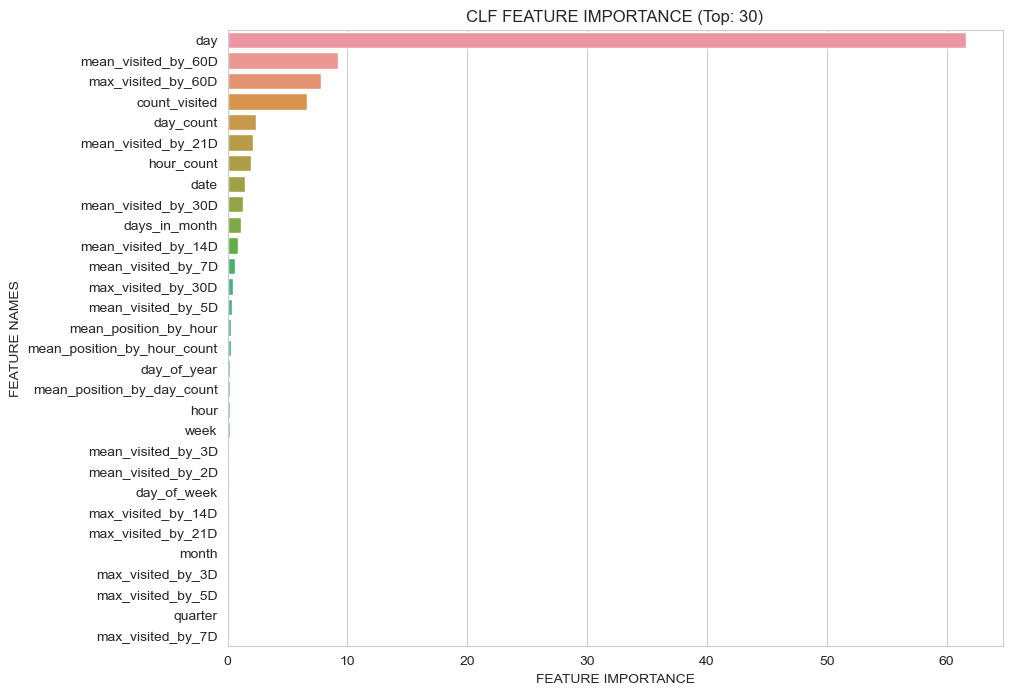

In [464]:
# Важность признаков
fi_df_model_reg = plot_feature_importance(model_reg.get_feature_importance(), X_test.columns, model_name='REG', top_n=30)  

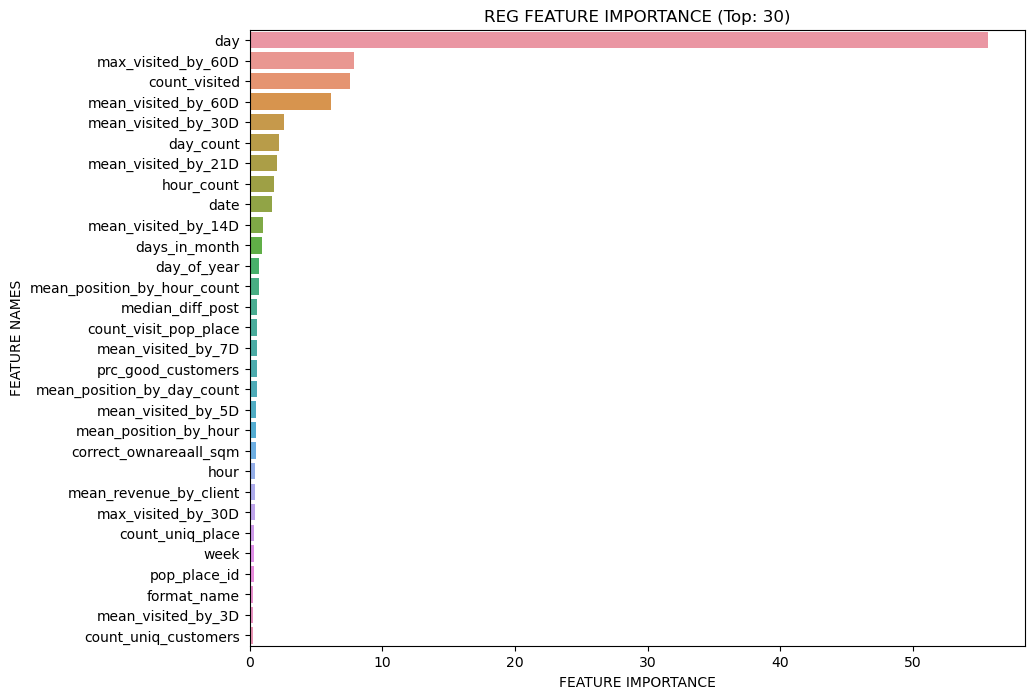

In [421]:
# Важность признаков
fi_df_model_reg = plot_feature_importance(model_reg.get_feature_importance(), X_test.columns, model_name='REG', top_n=30)  

# Тестовые данные

In [145]:
test_customer_df = test_data_df[['customer_id']].copy()

In [ ]:
105: threshold=0.52
106: threshold=0.45

In [194]:
average_proba_predict = model_clf.predict_proba(test_data_df[feature_columns])
test_customer_df['buy_post'] = [1 if pred >= 0.5 else 0 for pred in average_proba_predict[:,1]]

In [195]:
test_customer_df['date_diff_post'] = model_reg.predict(test_data_df[feature_columns])

In [196]:
test_customer_df[['customer_id', 'date_diff_post', 'buy_post']].to_csv('submission_v107.csv', sep=';', index=None)

# Подвал

In [426]:
1+2

3

In [436]:
# Заносим в общий датасет ид места
test_burger_df = test_burger_df.merge(place_df, on=['format_name', 'ownareaall_sqm'])
test_burger_df.shape

(2498034, 9)

### Формирование фич
Будем использовать бустинги  
Одна запись это 1 клиент  
Все данные по покупкам превращаем в фичи  

In [437]:
# Раскладываем даты по возможным начениям
test_burger_df['date'] = test_burger_df['startdatetime'].dt.date
test_burger_df['date'] = pd.to_datetime(test_burger_df['date'])
test_burger_df['year'] = test_burger_df['startdatetime'].dt.year
test_burger_df['month'] = test_burger_df['startdatetime'].dt.month
test_burger_df['day'] = test_burger_df['startdatetime'].dt.day
test_burger_df['day_of_week'] = test_burger_df['startdatetime'].dt.day_of_week
test_burger_df['day_of_year'] = test_burger_df['startdatetime'].dt.day_of_year
test_burger_df['days_in_month'] = test_burger_df['startdatetime'].dt.days_in_month
test_burger_df['quarter'] = test_burger_df['startdatetime'].dt.quarter
test_burger_df['week'] = test_burger_df['startdatetime'].dt.week
test_burger_df['hour'] = test_burger_df['startdatetime'].dt.hour

# Для группировки данных по дням определяем начальную дату и сколько прошло дней с этого момента
date_2022 = datetime.strptime("2022-01-01", "%Y-%m-%d", ).replace(tzinfo=None)
test_burger_df['day_count'] = ((test_burger_df['startdatetime'] - date_2022) / np.timedelta64(1, 'D')).astype(int)
# Для группировки данных по три часа также устанавливаем для каждой значения группу
test_burger_df['hour_count'] = ((test_burger_df['startdatetime'] - date_2022) / np.timedelta64(3, 'h')).astype(int)

C:\Users\Profit77\AppData\Local\Temp\ipykernel_5560\2877544811.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  test_burger_df['week'] = test_burger_df['startdatetime'].dt.week


In [572]:
# Создаем датафрейм для итоговых агрегатов по клиентам
test_customer_df = pd.DataFrame()

In [575]:
# Сколько позиций в день
mean_position_by_day = calc_position_by_time(test_burger_df, period_column='day_count')
# Сколько позиций в три часа
mean_position_by_3hour = calc_position_by_time(test_burger_df, period_column='hour_count')
# Сколько позиций в час
mean_position_by_hour = calc_position_by_time(test_burger_df, period_column='hour')

test_customer_df = pd.concat([test_customer_df, mean_position_by_day, mean_position_by_3hour, mean_position_by_hour], axis=1)
test_customer_df.shape

(112334, 3)

In [576]:
# Формируем сгруппированый датафрейм по посещениям за каждый день по каждому клиенту
visited_days_df = test_burger_df.groupby(by=['customer_id', 'date'])['dish_name'].count()
visited_days_df = pd.DataFrame(visited_days_df).reset_index()

In [577]:
def calc_stat_visited_by_period(period:str='1D'):
    calc_visited_df = pd.DataFrame([])
    select_group_visited = visited_days_df.set_index('date').groupby('customer_id')['customer_id'].rolling(period).count().groupby(by=['customer_id'])
    # calc_visited_df[f'count_visited_by_{period}'] = select_group_visited.count()
    calc_visited_df[f'max_visited_by_{period}'] = select_group_visited.max()
    calc_visited_df[f'mean_visited_by_{period}'] = select_group_visited.mean()
    return calc_visited_df

In [578]:
%%time
union_visited_df = pd.DataFrame(visited_days_df.set_index('date').groupby('customer_id')['customer_id'].rolling('1D').count().groupby(by=['customer_id']).count().rename('count_visited'))
for period in ['2D', '3D', '5D', '7D', '14D', '21D', '30D', '60D']:
    print(f'calc period: {period}')
    visited_df = calc_stat_visited_by_period(period=period)
    union_visited_df = pd.concat([union_visited_df, visited_df], axis=1)
union_visited_df.shape

calc period: 2D
calc period: 3D
calc period: 5D
calc period: 7D
calc period: 14D
calc period: 21D
calc period: 30D
calc period: 60D
CPU times: total: 19.8 s
Wall time: 19.7 s


(112334, 17)

In [579]:
# union_visited_df

In [580]:
test_customer_df = pd.concat([test_customer_df, union_visited_df], axis=1)
test_customer_df.shape

(112334, 20)

In [581]:
# В качестве общих признаков по дате используем последние записи по сгруппированным по клиенту данным
last_row_burger_columns = ['format_name', 'year', 'month', 'day', 
                         'day_count', 'day_of_week', 'day_of_year', 
                         'days_in_month', 'quarter', 'week', 
                         'hour_count', 'hour', 'date', 'correct_ownareaall_sqm']
last_row_df = test_burger_df[['customer_id', 'startdatetime'] + last_row_burger_columns].sort_values(by='startdatetime').groupby(by=['customer_id'])[last_row_burger_columns].last()
test_customer_df = pd.concat([test_customer_df, last_row_df], axis=1)
test_customer_df.shape

(112334, 34)

In [582]:
# Сколько уникальных мест посещал клиент или только в один ходит
# count_uniq_place_df = burger_df.groupby(by=['customer_id']).agg({"place_id": pd.Series.nunique}).rename(columns={'place_id': 'count_uniq_place'})
count_uniq_place_df = test_burger_df.groupby(by=['customer_id']).agg(count_uniq_place=("place_id", pd.Series.nunique))
test_customer_df = pd.concat([test_customer_df, count_uniq_place_df], axis=1)
test_customer_df.shape

(112334, 35)

In [583]:
# Определяем приоритетное кафе у клиента
client_pop_place_df = test_burger_df.groupby(by=['customer_id', 'place_id']).agg(count_visit=('startdatetime', len))
client_pop_place_df = client_pop_place_df.reset_index()

# Ищем какие места клиент посещал чаще других, в случаи совпадений берем последний
client_pop_place_df = client_pop_place_df[client_pop_place_df['count_visit'] == client_pop_place_df.groupby(['customer_id'])['count_visit'].transform(max)]
client_pop_place_df = client_pop_place_df.groupby(by=['customer_id']).last()
client_pop_place_df = client_pop_place_df.rename(columns={'place_id': 'pop_place_id', 'count_visit': 'count_visit_pop_place'})
client_pop_place_df.shape

(112334, 2)

In [584]:
# client_pop_place_df

In [585]:
# client_pop_place_df#.reset_index().set_index('customer_id')

In [586]:
test_customer_df = test_customer_df.merge(client_pop_place_df, on='customer_id')
test_customer_df.shape

(112334, 37)

In [587]:
test_customer_df = test_customer_df.reset_index().merge(place_features_df, left_on='pop_place_id', right_on='place_id')
test_customer_df = test_customer_df.set_index('customer_id')
test_customer_df.shape

(112334, 49)

In [588]:
# df_grouped = tmp_df.groupby(['customer_id', 'place_id']).agg({'count_visit':'max'})
# # df_grouped = df_grouped.reset_index()
# # df_grouped = df_grouped.rename(columns={'count_visit':'count_max'})
# # tmp_df_2 = pd.merge(tmp_df, df_grouped, how='left', on=['customer_id', 'place_id'])
# # # tmp_df_2 = tmp_df[tmp_df['count_visit'] == tmp_df['count_max']]
# # tmp_df_2
# df_grouped

In [589]:
# tmp_df[tmp_df['customer_id'] == 29891].groupby(['customer_id', 'place_id'])["count_visit"].idxmax()
# # tmp_df.groupby(['customer_id', 'place_id'])["count_visit"].idxmax()

In [590]:
# tmp_df.loc[tmp_df.groupby(['customer_id', 'place_id'])["count_visit"].idxmax()]

In [591]:
# # tmp_df2 = tmp_df.sort_values('count_visit').drop_duplicates(['customer_id', 'place_id'], keep='last')
# tmp_df2 = tmp_df.sort_values('count_visit').groupby(['customer_id', 'place_id']).tail(1)

In [592]:
customer_df.shape, test_customer_df.shape


((500000, 51), (112334, 49))

In [566]:
# X_train.shape

In [594]:
test_customer_df = test_customer_df.reset_index()

In [595]:
set(X_train.columns) - set(test_customer_df) 

set()

In [ ]:
test_customer_df

In [627]:
# test_proba_predictions = []
# for name, model in tqdm(classifiers):
#     print(name)
#     if name == 'CatBoost :':
#         ans_X_test = test_customer_df[feature_columns].copy()
#     else:
#         ans_X_test = test_customer_df[numeric_columns].copy()
#     test_proba_predictions.append(model.predict_proba(ans_X_test))

In [602]:
# # Усреднение вероятностей
# average_proba_predict = np.mean(np.array(test_proba_predictions), axis=0)
# test_customer_df['buy_post'] = [1 if pred >= 0.5 else 0 for pred in average_proba_predict[:,1]]


In [626]:
# %%time
# # Обучаем k моделей
# test_regressor_predictions = []
# for name, model in tqdm(regressors):
#     print(name)
#     if name == 'CatBoost :':
#         ans_X_test = test_customer_df[feature_columns].copy()
#     else:
#         ans_X_test = test_customer_df[numeric_columns].copy()        
#     test_regressor_predictions.append(model.predict(ans_X_test))

In [622]:
# # Усреднение вероятностей
# average_regressor_predict = np.mean(np.array(test_regressor_predictions), axis=0)
# test_customer_df['date_diff_post'] = average_regressor_predict



In [652]:
test_customer_df['buy_post'] = model_clf.predict(test_customer_df[feature_columns])

In [653]:
test_customer_df['date_diff_post'] = model_reg.predict(test_customer_df[feature_columns])

In [654]:
test_customer_df[['customer_id', 'date_diff_post', 'buy_post']].to_csv('submission_v103.csv', sep=';', index=None)

# Подвал

In [286]:
visited_df = calc_stat_visited_by_period(period='3D')
union_visited_df = pd.concat([union_visited_df, visited_df], axis=1)
union_visited_df.shape

(500000, 6)

In [323]:
period

'3D'

In [322]:
select_group_visited = visited_days_df.set_index('date').groupby('customer_id')['customer_id'].rolling(period).count()
# .groupby(by=['customer_id'])
select_group_visited

customer_id  date      
29891        2022-12-05    1.0
             2022-12-15    1.0
             2022-12-20    1.0
             2022-12-21    2.0
             2022-12-22    3.0
                          ... 
46624509     2023-08-01    2.0
46625265     2023-07-31    1.0
46639170     2023-07-31    1.0
46654016     2023-08-01    1.0
46661804     2023-08-01    1.0
Name: customer_id, Length: 2432418, dtype: float64

In [ ]:
select_group_visited

In [321]:
select_group_visited.count()
# tmp_df = pd.DataFrame(tmp_df)
# tmp_df.reset_index()
# tmp_df[tmp_df['customer_id'] == 29891]

# tmp_df.loc[29891]


customer_id
29891       19
30477       21
31426       20
44491        3
44939        3
            ..
46624509     2
46625265     1
46639170     1
46654016     1
46661804     1
Name: customer_id, Length: 500000, dtype: int64

In [ ]:
# Статистика по позициям за период через rolling

In [338]:
# tmp_df = visited_days_df.set_index('date').groupby('customer_id')['customer_id'].rolling('2D').count()


In [271]:
tmp_df.groupby(by=['customer_id']).count()

customer_id
29891       19
30477       21
31426       20
44491        3
44939        3
            ..
46624509     2
46625265     1
46639170     1
46654016     1
46661804     1
Name: customer_id, Length: 500000, dtype: int64

In [ ]:
# Сколько в неделю в месяц В два месяца в две недели

In [189]:
burger_df['date'] = pd.to_datetime(burger_df['date'])

In [240]:
%%time
# df.groupby('A').rolling(2, min_periods=1).sum()
# burger_df[burger_df['customer_id'] == 29891].groupby(by=['customer_id', 'hour_count'])['dish_name'].count().rolling(3, min_periods=1).sum()
# burger_df[burger_df['customer_id'] == 29891][['customer_id', 'startdatetime']].groupby(by=['customer_id'])[['customer_id', 'startdatetime']].count()#.rolling('2D').count()


# burger_df[burger_df['customer_id'] == 29891].groupby(by=['startdatetime'])['startdatetime'].count().rolling('2D').count()

# burger_df[burger_df['customer_id'] == 29891].groupby(by=['date'])['dish_name'].count()#.mean()#['date'].count().rolling('2D').count()
# pd.DataFrame(burger_df[burger_df['customer_id'] == 29891].groupby(by=['date'])['dish_name'].count()).rolling('2D').count()
# burger_df[burger_df['customer_id'] == 29891].groupby(by=['date'])['date'].count().rolling('2D').count()
# burger_df[burger_df['customer_id'] == 29891].groupby(by=['startdatetime'])['startdatetime'].count()#.rolling('2D').count()
# burger_df[burger_df['customer_id'] == 29891].groupby(by=['date'])['date'].count().rolling('2D').count()


# burger_df[burger_df['customer_id'] == 29891].groupby(by=['date'])['date'].count().rolling('2D').count()

# burger_df[burger_df['customer_id'] == 29891].groupby(by=['date'])['date'].count().rolling('2D').count()
# burger_df[burger_df['customer_id'] == 29891].groupby(by=['date'])['date'].count().rolling('2D').count()
# burger_df.set_index('date').groupby('customer_id').count()['startdatetime'].rolling('2D').count()



# burger_df.set_index('date').groupby('customer_id')['customer_id'].rolling('2D').count()

CPU times: total: 1.09 s
Wall time: 1.1 s


customer_id  date      
29891        2022-12-05     5
             2022-12-15     2
             2022-12-20     1
             2022-12-21     2
             2022-12-22     1
                           ..
46624509     2023-08-01     5
46625265     2023-07-31    13
46639170     2023-07-31    11
46654016     2023-08-01     6
46661804     2023-08-01    15
Name: dish_name, Length: 2432418, dtype: int64

In [244]:
# tmp_df = pd.DataFrame(tmp_df)
# tmp_df = tmp_df.reset_index()
# tmp_df[tmp_df['customer_id'] == 46624509]
tmp_df.set_index('date').groupby('customer_id')['customer_id'].rolling('2D').count().max()

2.0

In [255]:
select_group_visited = visited_days_df.set_index('date').groupby('customer_id')['customer_id'].rolling('2D').count().rename('count_visited_by_days').reset_index().groupby('customer_id')['count_visited_by_days']

# .reset_index().groupby('customer_id')['customer_id']#.mean()

,count_visited_by_days,max_visited_by_days,mean_visited_by_days
customer_id,,,
29891,19,2.0,1.526316
30477,21,2.0,1.571429
31426,20,2.0,1.350000
44491,3,2.0,1.333333
44939,3,1.0,1.000000
...,...,...,...
46624509,2,2.0,1.500000
46625265,1,1.0,1.000000
46639170,1,1.0,1.000000


In [257]:
select_group_visited.max()

customer_id
29891       2.0
30477       2.0
31426       2.0
44491       2.0
44939       1.0
           ... 
46624509    2.0
46625265    1.0
46639170    1.0
46654016    1.0
46661804    1.0
Name: count_visited_by_days, Length: 500000, dtype: float64

In [ ]:
# visited_days_df.set_index('date').groupby('customer_id')['customer_id'].rolling('2D').count().reset_index().groupby('customer_id').max()

In [254]:
len(burger_df[burger_df['customer_id'] == 29891]['date'].unique())

19

In [238]:
burger_df[burger_df['customer_id'] == 29891]

,customer_id,date_diff_post,buy_post,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,year,...,day,day_count,day_of_week,day_of_year,days_in_month,quarter,week,hour_count,hour,date
24261882,46625265,NaN,0,train,59.99,2023-07-31 15:25:09,Чикенбургер новый,120.0,Фудкорт с туалетом,2023,...,31,576,0,212,31,3,31,4613,15,2023-07-31
24261883,46625265,NaN,0,train,119.99,2023-07-31 15:25:09,"Липтон Лимон в бутылке 0,5л",120.0,Фудкорт с туалетом,2023,...,31,576,0,212,31,3,31,4613,15,2023-07-31
24261884,46625265,NaN,0,train,119.99,2023-07-31 15:25:09,Острые Луковые Кольца 9Шт,120.0,Фудкорт с туалетом,2023,...,31,576,0,212,31,3,31,4613,15,2023-07-31
24261885,46625265,NaN,0,train,49.99,2023-07-31 15:25:09,Соус Сырный,120.0,Фудкорт с туалетом,2023,...,31,576,0,212,31,3,31,4613,15,2023-07-31
24261886,46625265,NaN,0,train,49.99,2023-07-31 15:37:34,Соус Сырный,120.0,Фудкорт с туалетом,2023,...,31,576,0,212,31,3,31,4613,15,2023-07-31
24261887,46625265,NaN,0,train,49.99,2023-07-31 15:46:52,Соус Сырный,120.0,Фудкорт с туалетом,2023,...,31,576,0,212,31,3,31,4613,15,2023-07-31
24261888,46625265,NaN,0,train,169.98,2023-07-31 15:46:52,Воппер Ролл,120.0,Фудкорт с туалетом,2023,...,31,576,0,212,31,3,31,4613,15,2023-07-31
24261889,46625265,NaN,0,train,70.00,2023-07-31 15:46:52,Кинг Фри станд,120.0,Фудкорт с туалетом,2023,...,31,576,0,212,31,3,31,4613,15,2023-07-31
24261890,46625265,NaN,0,train,70.00,2023-07-31 15:46:52,Кинг Фри станд,120.0,Фудкорт с туалетом,2023,...,31,576,0,212,31,3,31,4613,15,2023-07-31
24261891,46625265,NaN,0,train,109.99,2023-07-31 15:46:52,"Липтон Лимон в бутылке 0,5л",120.0,Фудкорт с туалетом,2023,...,31,576,0,212,31,3,31,4613,15,2023-07-31


In [111]:
burger_df[burger_df['customer_id'] == 29891]

,customer_id,date_diff_post,buy_post,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,year,month,day,day_count,day_of_week,day_of_year,days_in_month,quarter,week,hour_count,hour
0,29891,9.0,1,train,69.99,2022-12-05 12:03:58,Кинг Фри станд,300.0,Отдельно стоящий без внешней зоны,2022,12,5,338,0,339,31,4,49,2708,12
1,29891,9.0,1,train,190.00,2022-12-05 12:03:58,Чикен Тар-Тар,300.0,Отдельно стоящий без внешней зоны,2022,12,5,338,0,339,31,4,49,2708,12
2,29891,9.0,1,train,9.99,2022-12-05 12:03:58,Соус Сырный,300.0,Отдельно стоящий без внешней зоны,2022,12,5,338,0,339,31,4,49,2708,12
3,29891,9.0,1,train,119.99,2022-12-05 12:03:58,Энергет.нап. Адреналин Раш,300.0,Отдельно стоящий без внешней зоны,2022,12,5,338,0,339,31,4,49,2708,12
4,29891,9.0,1,train,119.99,2022-12-05 14:28:35,Латте (СТАНД.),300.0,Отдельно стоящий без внешней зоны,2022,12,5,338,0,339,31,4,49,2708,14
5,29891,9.0,1,train,60.00,2022-12-15 00:37:19,Чизбургер,463.0,Отдельно стоящий с внешней зоной,2022,12,15,348,3,349,31,4,50,2784,0
6,29891,9.0,1,train,209.99,2022-12-15 00:37:19,Воппер Ролл,463.0,Отдельно стоящий с внешней зоной,2022,12,15,348,3,349,31,4,50,2784,0
7,29891,9.0,1,train,144.97,2022-12-20 09:20:38,ЧизБекон Чикен Гамбургер,463.0,Отдельно стоящий с внешней зоной,2022,12,20,353,1,354,31,4,51,2827,9
8,29891,9.0,1,train,184.96,2022-12-21 09:46:23,Цезарь Кинг новый,463.0,Отдельно стоящий с внешней зоной,2022,12,21,354,2,355,31,4,51,2835,9
9,29891,9.0,1,train,84.99,2022-12-21 13:12:09,Flash Up,463.0,Отдельно стоящий с внешней зоной,2022,12,21,354,2,355,31,4,51,2836,13


In [96]:
# mean_position_by_3hour_df

In [108]:
customer_df

,mean_position_by_day_count,mean_position_by_hour_count,mean_position_by_hour
customer_id,,,
29891,1.789474,1.478261,3.400000
30477,2.904762,2.541667,7.625000
31426,4.300000,3.739130,7.818182
44491,3.333333,3.333333,3.333333
44939,8.333333,8.333333,8.333333
...,...,...,...
46624509,5.500000,3.666667,3.666667
46625265,13.000000,13.000000,13.000000
46639170,11.000000,5.500000,3.666667


In [ ]:
position_by_day_df.groupby(by=['customer_id', 'day_count'])['dish_name'].count()
position_by_day_df.groupby(by=['customer_id', 'day_count'])['dish_name'].count()

In [55]:
burger_df['mean_position_by_day']

0           2708
1           2708
2           2708
3           2708
4           2708
            ... 
24261974    4622
24261975    4622
24261976    4622
24261977    4622
24261978    4622
Name: hour_count, Length: 12129384, dtype: int32

In [339]:
# dir(burger_df['startdatetime'].dt)

In [ ]:
# Кол-во покупок в один день.


In [ ]:
# Кол-во покупок в три часа. Показывает, что человек мог сидеть в бургеркинге и дозаказывать, значит пришел на посидеть. 
# Можно сделать предположение, что те кто постоянно ходят в бургер кинг например по утрам, то делают заказ сразу весь. А те кто сидит долго по вечерам с друзьями то несколько заказов делает

In [ ]:
burger_df[burger_df['customer_id'] == 29891]

In [ ]:
Что предсказываем?
Что будет в тесте?

Если человек был один раз то это 0
Если человек был один раз, а второй через 59 дней и мы прогнозирукем что он появится в 3

Что за три даты?